<a href="https://colab.research.google.com/github/Rabidgeek/DAISY/blob/main/JMR_LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

## Initial Setup:

In [1]:
# Set up Colab and Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/Colab Notebooks/BloomTech/KaggleChallenge/ethereum/
!ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/BloomTech/KaggleChallenge/ethereum
eth_historical.csv


In [157]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import plotly.graph_objects as go

from sklearn import preprocessing, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

## Wrangling Data

In [3]:
# Wrangle Data
def wrangle(data):
  df = pd.read_csv(data,
                   parse_dates=['Date'],
                   index_col=['Date'])
  df.columns = [x.lower() for x in df.columns]
  
  # Engineer Features
  #df['adj open'] = df['open']
  #df['delta'] = round(((df['close'] - df['open']) / df['close']) * 100,2)
  

  # Drop open and close columns to avoid data leakage
  #df.drop(columns=['open', 'close'], inplace=True)

  # Drop NaN
  df.dropna(inplace=True)

  return df

data = "/content/gdrive/MyDrive/Colab Notebooks/BloomTech/KaggleChallenge/ethereum/eth_historical.csv"

In [4]:
eth = wrangle(data)
eth.head()

,open,high,low,close,volume,adj close
Date,,,,,,
2022-09-16,1471.928345,1480.564209,1415.581299,1432.447754,16764804299,1432.447754
2022-09-17,1432.876465,1473.060425,1415.042358,1469.741699,10798098671,1469.741699
2022-09-18,1469.705444,1469.705444,1331.494751,1335.329102,15762284723,1335.329102
2022-09-19,1335.270752,1388.272217,1287.420898,1377.541382,18712714223,1377.541382
2022-09-20,1377.619019,1381.965698,1319.201416,1324.388184,14722317220,1324.388184


In [5]:
target = 'adj close'
required = ['open', 'high', 'low', 'volume']

X = eth[required]
y = eth[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state = 42)

## Baseline Metrics

In [7]:
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)

rmse = mean_squared_error(y_train, y_pred)
lin_rmse = np.sqrt(rmse)

print('Mean Sale Price:', y_train.mean())
print('Baseline MAE:', baseline_mae)
print('Linear Regression RMSE: ', lin_rmse)

Mean Sale Price: 1367.560926072141
Baseline MAE: 88.59903190339948
Linear Regression RMSE:  114.73642406928981


# Build Models

In [8]:
# Build LinearRegression Model
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [154]:
# Build Ridge Regression Model
model_rr = make_pipeline(
    StandardScaler(),
    decomposition.PCA(),
    Ridge(alpha=10, max_iter=None, fit_intercept=True)
)
model_rr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('ridge', Ridge(alpha=10))])

In [158]:
# GridSearch Model
param = {'alpha': [0,.5,1,1.5,2,2.5,3,4,5,6,7.5,8,8.5,9,9.5,10] , 
         'fit_intercept': [True, False]}

model_rr_gs = Ridge()
model_gs = GridSearchCV(model_rr_gs, param, n_jobs=-1)
model_gs.fit(X_train, y_train)
model_gs.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=1.1582e-18): result may not be accurate.



{'alpha': 10, 'fit_intercept': False}

In [156]:
# RandomizedSearch Model
model_rs = RandomizedSearchCV(model_rr_gs, param, n_jobs=-1)
model_rs.fit(X_train, y_train)
model_rs.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=1.22163e-18): result may not be accurate.



{'fit_intercept': False, 'alpha': 1000}

In [148]:
# Build Gradient Boosted Model

model_gb = make_pipeline(
    GradientBoostingRegressor(random_state=42, n_estimators=95, max_features=.8)
)
model_gb.fit(X_train, y_train)

Pipeline(steps=[('gradientboostingregressor',
                 GradientBoostingRegressor(max_features=0.8, n_estimators=95,
                                           random_state=42))])

In [11]:
# Build XGB Model

model_xgb = make_pipeline(
    XGBRegressor(random_state=42, n_estimators=95, n_jobs=-1, max_features=.8)
)

model_xgb.fit(X_train, y_train)

[19:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('xgbregressor',
                 XGBRegressor(max_features=0.8, n_estimators=95, n_jobs=-1,
                              random_state=42))])

In [12]:
model.score(X_test, y_test)

0.9532208435238853

In [149]:
model_rr.score(X_test, y_test)

0.9612604057587606

In [150]:
model_gs.score(X_test, y_test)

0.9458530314352066

In [151]:
model_rs.score(X_test, y_test)

0.9455335726584471

In [14]:
model_gb.score(X_test, y_test)

0.9165807736255649

In [15]:
model_xgb.score(X_test, y_test)

0.9175192648923002

In [16]:
future_set = eth.shift(periods=30).tail(30)
future_set.dropna(inplace=True)

In [17]:
future_set.head()

,open,high,low,close,volume,adj close
Date,,,,,,
2022-10-16,1471.928345,1480.564209,1415.581299,1432.447754,1.676480e+10,1432.447754
2022-10-16,1432.876465,1473.060425,1415.042358,1469.741699,1.079810e+10,1469.741699
2022-10-17,1469.705444,1469.705444,1331.494751,1335.329102,1.576228e+10,1335.329102
2022-10-18,1335.270752,1388.272217,1287.420898,1377.541382,1.871271e+10,1377.541382
2022-10-19,1377.619019,1381.965698,1319.201416,1324.388184,1.472232e+10,1324.388184


In [18]:
y_pred = model.predict(future_set[required])

print('My LinearRegression predictions:', y_pred)

My LinearRegression predictions: [1428.00311172 1447.16037907 1351.37576634 1339.9842797  1332.3323783
 1296.73389464 1315.89738372 1302.88293486 1331.07127862 1297.09238665
 1320.30321084 1364.56980555 1298.53796345 1310.44985083 1350.77475147
 1314.12482539 1286.90257419 1315.78249961 1355.40203157 1328.0345576
 1372.39405424 1333.08052275 1314.84938628 1321.36800506 1308.46443985
 1282.63058176 1299.5927526  1229.58165277 1330.4192328 ]


In [152]:
y_rr_pred = model_rr.predict(future_set[required])

print('My Ridge Regression predictions:', y_rr_pred)

My Ridge Regression predictions: [1438.46770907 1435.60453781 1393.66828519 1338.37417982 1352.05029853
 1308.54541421 1294.46690503 1316.02999559 1334.52618468 1311.47363972
 1314.70716509 1352.3247339  1314.36851843 1325.75549402 1347.03600068
 1326.60938207 1304.99722158 1306.43127001 1345.77905271 1345.53197726
 1366.13506799 1344.591738   1328.53799203 1326.21911255 1320.37755899
 1295.35231638 1300.39063601 1264.27364382 1318.29955138]


In [22]:
y_gb_pred = model_gb.predict(future_set[required])

print('My GradientBoostingRegressor predictions:', y_gb_pred)

My GradientBoostingRegressor predictions: [1486.30096049 1470.10503118 1335.72636712 1326.61662441 1327.75174772
 1335.47828948 1326.21328971 1325.78487626 1318.99517774 1297.03590168
 1329.92086901 1332.6285497  1324.29778692 1309.73842546 1329.01972731
 1311.19248201 1278.66353128 1323.32265514 1359.4198095  1350.98986782
 1353.01096672 1336.49923314 1314.59665676 1321.02418788 1293.99800669
 1286.13446163 1294.27334225 1287.89372454 1300.26050497]


In [67]:
y_xgb_pred = model_xgb.predict(future_set[required])

print('My GradientBoostingRegressor predictions:', y_xgb_pred)

My GradientBoostingRegressor predictions: [1470.885  1469.4037 1335.7675 1324.9474 1327.0973 1314.0906 1321.7288
 1324.5516 1315.7264 1299.3086 1321.0466 1336.1333 1324.5516 1305.2854
 1329.9332 1313.3013 1283.0626 1321.314  1355.1184 1350.8862 1363.3389
 1336.9756 1315.323  1320.3776 1298.1573 1288.0458 1291.8772 1286.152
 1307.3212]


## Visualizations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f613058b4f0>,
      dtype=object)

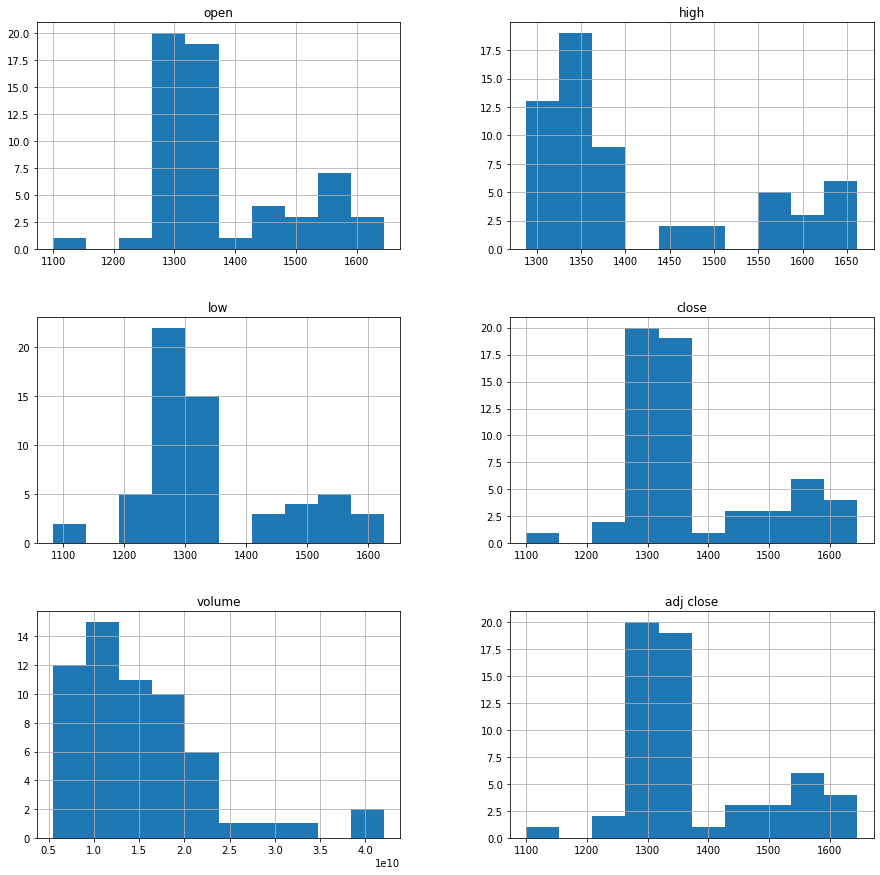

In [68]:
# Plot Distribution of Values
eth.hist(figsize=(15,15))

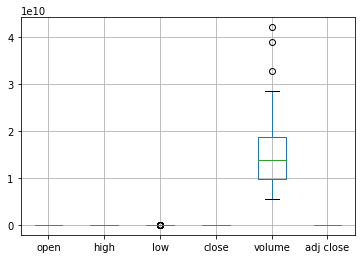

In [69]:
eth.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f613025f670>,
      dtype=object)

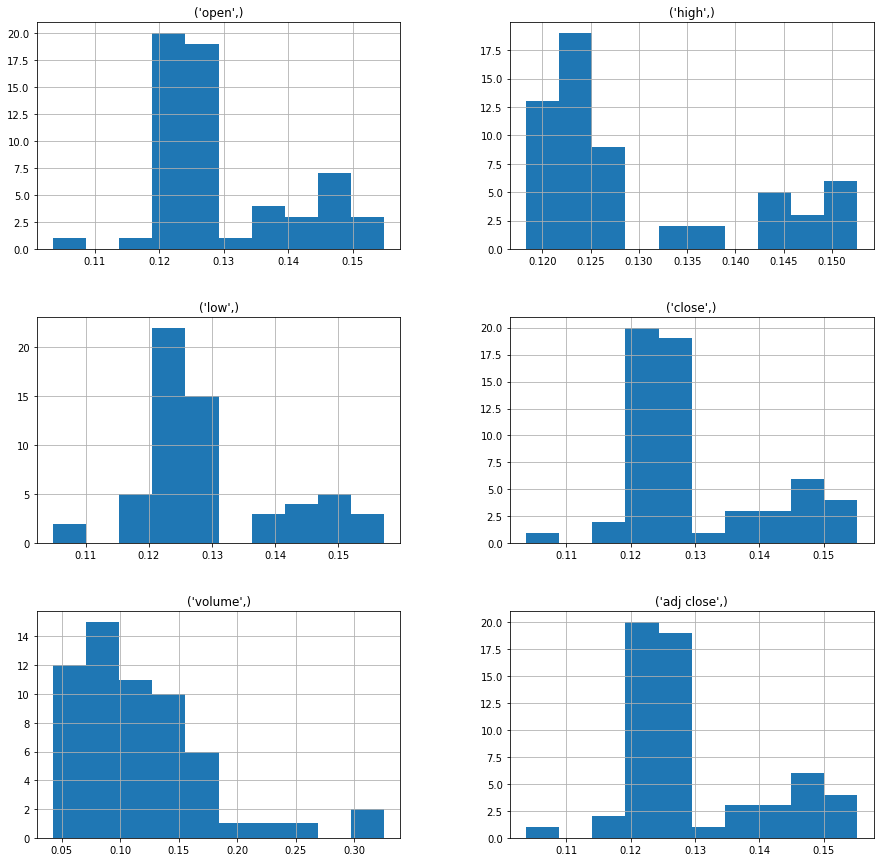

In [70]:
# Normalize Data
eth_norm = preprocessing.normalize(eth, axis=0)
eth_df = pd.DataFrame(eth_norm, columns=[eth.columns])

eth_df.hist(figsize=(15,15))

In [71]:
# MinMaxScaler

scaler = preprocessing.MinMaxScaler(feature_range=(0,2))
norm =scaler.fit_transform(eth)
eth_norm_df = pd.DataFrame(norm, columns=[eth.columns])
print('OG Data:\n',eth.head(10))
print('***************************************************************************\n')
print('Normalized Data with MinMaxScaler:\n',eth_norm_df.head(10))

OG Data:
                    open         high          low        close       volume  \
Date                                                                          
2022-09-16  1471.928345  1480.564209  1415.581299  1432.447754  16764804299   
2022-09-17  1432.876465  1473.060425  1415.042358  1469.741699  10798098671   
2022-09-18  1469.705444  1469.705444  1331.494751  1335.329102  15762284723   
2022-09-19  1335.270752  1388.272217  1287.420898  1377.541382  18712714223   
2022-09-20  1377.619019  1381.965698  1319.201416  1324.388184  14722317220   
2022-09-21  1324.215576  1384.476929  1229.426758  1252.607788  20643507800   
2022-09-22  1251.567383  1336.157837  1240.968262  1327.680176  18461527259   
2022-09-23  1327.481201  1353.288330  1270.198364  1328.259521  18771106339   
2022-09-24  1328.244629  1346.255249  1312.640259  1317.993286  12098209717   
2022-09-25  1317.938477  1333.371338  1275.627686  1294.216797  11802651633   

              adj close  
Date           

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f612ff8ccd0>,
      dtype=object)

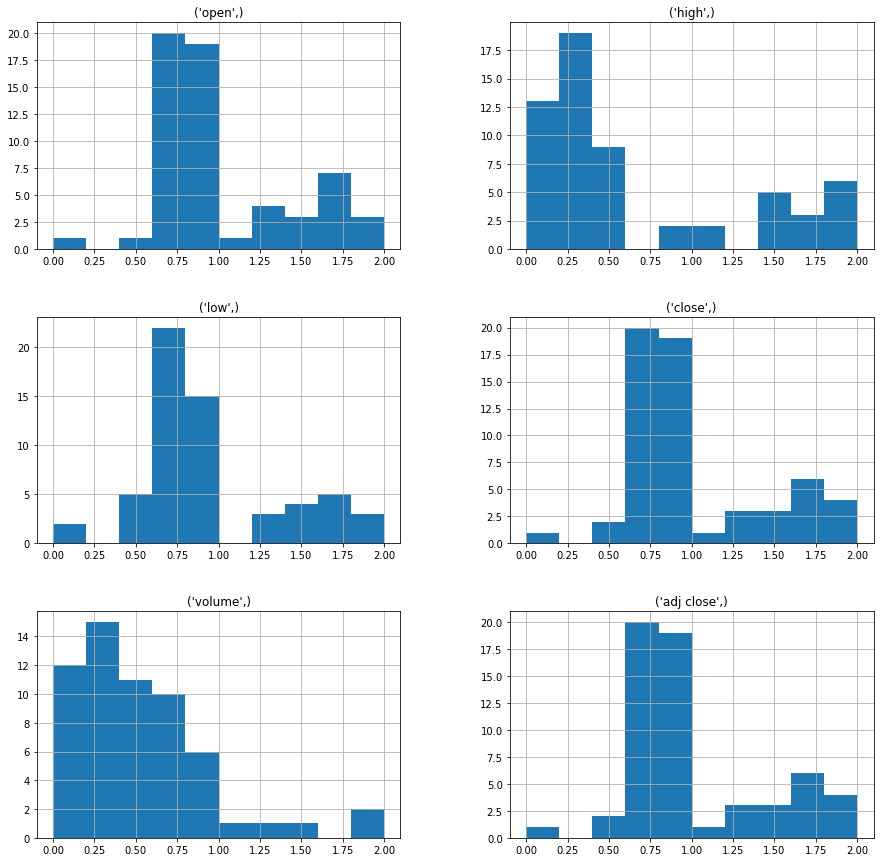

In [72]:
eth_norm_df.hist(figsize=(15,15))

In [73]:
# Visualize Ethereum Historic Data
fig = go.Figure(data=[go.Candlestick(x=eth.index,
                                     open=eth['open'],
                                     high=eth['high'],
                                     low=eth['low'],
                                     close=eth['close'],
                                     )])
fig.update_layout(
    title = "Ethereum Historical Data",
    yaxis_title = 'Value in USD')
    
fig.show()

Text(0, 0.5, 'Price')

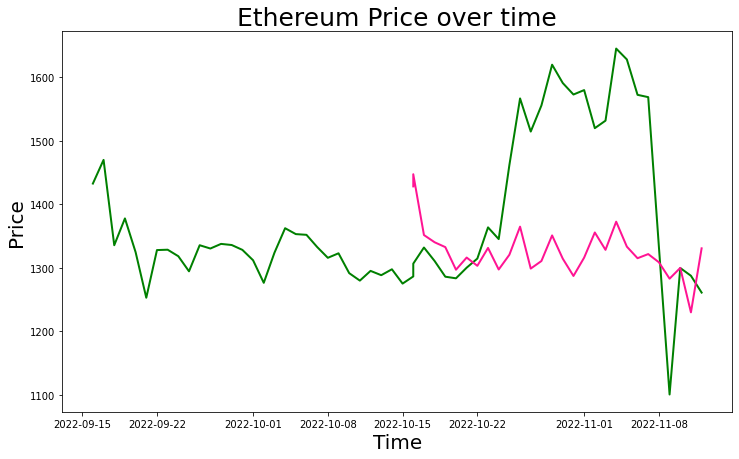

In [74]:
# Visualize Eth Predictions
plt.figure(figsize=(12,7))
plt.plot(eth.index, eth['adj close'], color='green', lw=2)
plt.plot(future_set.index, y_pred, color='deeppink', lw=2)
plt.title("Ethereum Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Price", size=20)

# Feature Importances

Text(0, 0.5, 'Feature')

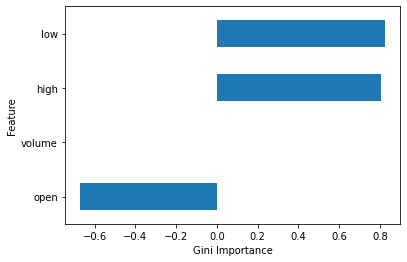

In [75]:
importances = model.coef_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()

feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

Text(0, 0.5, 'Feature')

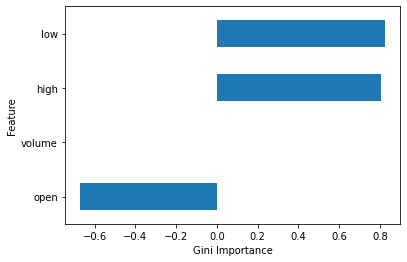

In [153]:
importances_rr = model.coef_
feature_names_rr = X_train.columns
feat_imp_rr = pd.Series(data=importances_rr, index=feature_names_rr).sort_values()

feat_imp_rr.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

Text(0, 0.5, 'Feature')

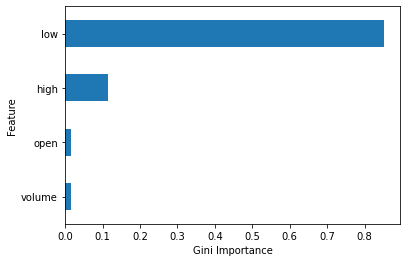

In [77]:
importances_gb = model_gb.named_steps['gradientboostingregressor'].feature_importances_
feature_names_gb = X_train.columns
feat_imp_gb = pd.Series(data=importances_gb, index=feature_names_gb).sort_values()

feat_imp_gb.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

Text(0, 0.5, 'Feature')

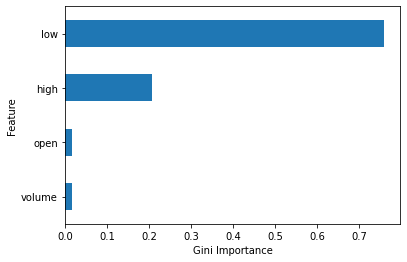

In [78]:
importances_xgb = model_xgb.named_steps['xgbregressor'].feature_importances_
feature_names_xgb = X_train.columns
feat_imp_xgb = pd.Series(data=importances_xgb, index=feature_names_xgb).sort_values()

feat_imp_xgb.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

# Check Metrics

In [79]:
print('LinearRegression Training Accuracy', model.score(X_train, y_train))
print('LinearRegression Test Accuracy', model.score(X_test, y_test))

LinearRegression Training Accuracy 0.9780281308594126
LinearRegression Test Accuracy 0.9532208435238853


In [96]:
print('Ridge Regression Training Accuracy', model_rr.score(X_train, y_train))
print('Ridge Regression Test Accuracy', model_rr.score(X_test, y_test))

Ridge Regression Training Accuracy 0.9086965455829852
Ridge Regression Test Accuracy 0.9612604057587606


In [81]:
print('GradientBoostingRegressor Training Accuracy', model_gb.score(X_train, y_train))
print('GradientBoostingRegressor Test Accuracy', model_gb.score(X_test, y_test))

GradientBoostingRegressor Training Accuracy 0.999725100804981
GradientBoostingRegressor Test Accuracy 0.9165807736255649


In [82]:
print('XGBRegressor Training Accuracy', model_xgb.score(X_train, y_train))
print('XGBRegressor Test Accuracy', model_xgb.score(X_test, y_test))

XGBRegressor Training Accuracy 0.9979750192926922
XGBRegressor Test Accuracy 0.9175192648923002


# Permutations

In [83]:
# Check Feature Importance Metrics LinearRegression
feature = 'low'
X_test_permuted = X_test.copy()

X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

X_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model.score(X_test, y_test))
print('Validation Accuracy (permuted)', model.score(X_test_permuted, y_test))

Feature permuted:  low
Validation Accuracy 0.9532208435238853
Validation Accuracy (permuted) -0.6237125291936538


In [84]:
# Check Feature Importance Metrics LinearRegression
feature1 = 'high'
X_test_permuted1 = X_test.copy()

X_test_permuted1[feature].fillna(value = X_test_permuted1[feature].median(), inplace=True)

X_test_permuted1[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature1)
print('Validation Accuracy', model.score(X_test, y_test))
print('Validation Accuracy (permuted)', model.score(X_test_permuted1, y_test))

Feature permuted:  high
Validation Accuracy 0.9532208435238853
Validation Accuracy (permuted) -1.022333169436394


In [97]:
# Check Feature Importance Metrics Ridge Regression
feature = 'low'
X_test_permuted_rr = X_test.copy()

X_test_permuted_rr[feature].fillna(value = X_test_permuted_rr[feature].median(), inplace=True)

X_test_permuted_rr[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model_rr.score(X_test, y_test))
print('Validation Accuracy (permuted)', model_rr.score(X_test_permuted_rr, y_test))

Feature permuted:  low
Validation Accuracy 0.9612604057587606
Validation Accuracy (permuted) 0.40087893847089495


In [98]:
# Check Feature Importance Metrics Ridge Regression
feature1 = 'high'
X_test_permuted1_rr = X_test.copy()

X_test_permuted1_rr[feature].fillna(value = X_test_permuted1_rr[feature].median(), inplace=True)

X_test_permuted1_rr[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature1)
print('Validation Accuracy', model_rr.score(X_test, y_test))
print('Validation Accuracy (permuted)', model_rr.score(X_test_permuted1_rr, y_test))

Feature permuted:  high
Validation Accuracy 0.9612604057587606
Validation Accuracy (permuted) 0.005855215487448162


In [87]:
# Check Feature Importance Metrics Gradient Boosting
feature_gb = 'low'
X_test_permuted_gb = X_test.copy()

X_test_permuted_gb[feature].fillna(value = X_test_permuted_gb[feature].median(), inplace=True)

X_test_permuted_gb[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model_gb.score(X_test, y_test))
print('Validation Accuracy (permuted)', model_gb.score(X_test_permuted_gb, y_test))

Feature permuted:  low
Validation Accuracy 0.9165807736255649
Validation Accuracy (permuted) 0.48856759107152226


In [88]:
# Check Feature Importance Metrics Gradient Boosting
feature1 = 'high'
X_test_permuted1_gb = X_test.copy()

X_test_permuted1_gb[feature].fillna(value = X_test_permuted1_gb[feature].median(), inplace=True)

X_test_permuted1_gb[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature1)
print('Validation Accuracy', model_gb.score(X_test, y_test))
print('Validation Accuracy (permuted)', model_gb.score(X_test_permuted1_gb, y_test))

Feature permuted:  high
Validation Accuracy 0.9165807736255649
Validation Accuracy (permuted) 0.16177133798952537


In [89]:
# Check Feature Importance Metrics Gradient Boosting
feature1 = 'delta'
X_test_permuted1_gb = X_test.copy()

X_test_permuted1_gb[feature].fillna(value = X_test_permuted1_gb[feature].median(), inplace=True)

X_test_permuted1_gb[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature1)
print('Validation Accuracy', model_gb.score(X_test, y_test))
print('Validation Accuracy (permuted)', model_gb.score(X_test_permuted1_gb, y_test))

Feature permuted:  delta
Validation Accuracy 0.9165807736255649
Validation Accuracy (permuted) -0.145316852214332


In [90]:
# Check Feature Importance Metrics XGBRegressor
feature_xgb = 'low'
X_test_permuted_xgb = X_test.copy()

X_test_permuted_xgb[feature].fillna(value = X_test_permuted_xgb[feature].median(), inplace=True)

X_test_permuted_xgb[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model_xgb.score(X_test, y_test))
print('Validation Accuracy (permuted)', model_xgb.score(X_test_permuted_xgb, y_test))

Feature permuted:  low
Validation Accuracy 0.9175192648923002
Validation Accuracy (permuted) 0.45361684988091133


In [91]:
# Check Feature Importance Metrics XGBRegressor
feature1 = 'high'
X_test_permuted1_xgb = X_test.copy()

X_test_permuted1_xgb[feature].fillna(value = X_test_permuted1_xgb[feature].median(), inplace=True)

X_test_permuted1_xgb[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature1)
print('Validation Accuracy', model_xgb.score(X_test, y_test))
print('Validation Accuracy (permuted)', model_xgb.score(X_test_permuted1_xgb, y_test))

Feature permuted:  high
Validation Accuracy 0.9175192648923002
Validation Accuracy (permuted) -0.03743676322739642


In [92]:
# Check Feature Importance Metrics XGBRegressor
feature1 = 'delta'
X_test_permuted1_xgb = X_test.copy()

X_test_permuted1_xgb[feature].fillna(value = X_test_permuted1_xgb[feature].median(), inplace=True)

X_test_permuted1_xgb[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature1)
print('Validation Accuracy', model_xgb.score(X_test, y_test))
print('Validation Accuracy (permuted)', model_xgb.score(X_test_permuted1_xgb, y_test))

Feature permuted:  delta
Validation Accuracy 0.9175192648923002
Validation Accuracy (permuted) -0.3553033755165247
